#  프로젝트

###### 사전 준비 

In [22]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [23]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [24]:
# 데이터 형태 확인
data.shape

(98401, 2)

In [25]:
# 데이터 일부 확인
data.sample(10)

,headlines,text
50607,Uber to launch bike service in Amritsar and Ka...,Ride-hailing startup Uber is planning to launc...
82548,It's like wine: Dhoni on getting better with age,Following his knock of 78*(79) against Windies...
84087,84% Indians want Yoga in school curriculum: In...,"On International Yoga Day, a poll by Inshorts ..."
16886,China imposes retaliatory tariffs on $60 bn of...,China on Tuesday announced tariffs on US goods...
60274,Odisha teen jumps off ambulance after driver a...,A 19-year-old girl jumped off a moving ambulan...
68797,Arvind Subramanian's term as CEA extended for ...,The government has extended the term of Chief ...
27506,Collapsed Mumbai bridge cleared safety audit i...,The overbridge that collapsed on Tuesday injur...
43108,"Chahal no. 2 in T20I rankings, Sundar jumps 15...",Indian leg-spinner Yuzvendra Chahal has jumped...
65109,"3 killed, 2 injured in shooting in US state of...",At least three people were killed and two othe...
6930,Robert Vadra is the fountainhead of corruption...,BJP spokesperson Sambit Patra on Saturday call...


### 데이터 전처리 1단계

###  중복 데이터 확인

######  'text' 열

In [26]:
# text열 데이터의 총 개수
len(data.text)

98401

In [27]:
# text열의 고유한 데이터의 개수
data.text.nunique()

98360

In [28]:
print(f"text 열에는 {len(data.text)-data.text.nunique()}개의 중복 데이터가 있습니다")

text 열에는 41개의 중복 데이터가 있습니다


In [29]:
# 중복된 데이터를 제거하겠습니다.
data.drop_duplicates(subset = ['text'], inplace = True)

In [30]:
# 결과 확인 
print(f"text 열에는 {len(data.text)-data.text.nunique()}개의 중복 데이터가 있습니다")

text 열에는 0개의 중복 데이터가 있습니다


######  'headlines' 열

In [31]:
print(f"headlines 열에는 {len(data.headlines)-data.headlines.nunique()}개의 중복 데이터가 있습니다")

headlines 열에는 98개의 중복 데이터가 있습니다


In [32]:
# 중복된 데이터를 제거하겠습니다.
data.drop_duplicates(subset = ['headlines'], inplace = True)

In [33]:
print(f"headlines 열에는 {len(data.headlines)-data.headlines.nunique()}개의 중복 데이터가 있습니다")

headlines 열에는 0개의 중복 데이터가 있습니다


### 결측치 확인 

In [34]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

### 중복 및 결측치 제거 데이터 확인

In [35]:
data = data.reset_index()

In [37]:
data.drop('index', axis = 1, inplace= True)

In [38]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [39]:
data.sample(10)

,headlines,text
7532,Man held for running prostitution racket in na...,A 70-year-old man has been arrested for allege...
216,Our stars play only positive roles all their l...,"Actor Nawazuddin Siddiqui, in a recent intervi..."
85956,Cadila now India's 2nd most valued drug firm w...,Cadila Healthcare has become India's second-mo...
86588,US cannot renegotiate Paris climate deal: Fran...,"In a rare joint statement, leaders of France, ..."
78203,Flyer at Delhi Airport hides gold worth Ã¢ÂÂ¹...,A 37-year-old man was arrested for allegedly t...
20275,"US, Afghanistan reject Russia-led peace talks ...",The US and Afghanistan will not attend Russia-...
51634,"Central Railway to install 11,000 CCTVs in all...","The Central Railway has planned to install 11,..."
21185,Became Lok Sabha Speaker due to Vajpayee: Shiv...,Senior Shiv Sena leader Manohar Joshi said he ...
31800,Nobody broke into our system: EC on fake IDs f...,"After nearly 10,000 fake voter IDs were found ..."
31342,"Fan enters field to touch Kohli's feet, take s...",A fan invaded the field and took a selfie with...


### 데이터 전처리 2단계

In [40]:
# 텍스트 정규화 
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [41]:
# 정규 표현식과 Counter 모듈을 통해 특이 데이터 색출 모색
'''
import re 

outlier = []
for i in data.text:
    outlier.append(re.match('[^a-zA-Z0-9_\'\"]' ,i)) 

for j in data.headlines:
    outlier.append(re.match('[^a-zA-Z0-9_\'\"]' ,j))
    
len(outlier)


from collections import Counter

outlier_hash = Counter(outlier)


outlier_hash.most_common()

'''

'\nimport re \n\noutlier = []\nfor i in data.text:\n    outlier.append(re.match(\'[^a-zA-Z0-9_\'"]\' ,i)) \n\nfor j in data.headlines:\n    outlier.append(re.match(\'[^a-zA-Z0-9_\'"]\' ,j))\n    \nlen(outlier)\n\n\nfrom collections import Counter\n\noutlier_hash = Counter(outlier)\n\n\noutlier_hash.most_common()\n\n'

In [42]:
#불용어 제거
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [43]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True): 
    sentence = sentence.lower() 
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1) # if문 두 번 사용
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [44]:
import multiprocessing as mp   
from multiprocessing import Pool
import numpy as np
import time
from functools import partial 

start = time.time()

def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  
    
  text_data_split = np.array_split(data, num_cores)  
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

clean_text = preprocess_data(data['text']) 
print(clean_text)

clean_headlines = preprocess_data(data['headlines'], remove_stopwords=False) 
print(clean_headlines)

222.4437255859375  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak 

In [45]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [46]:
# 결측치 확인 
data.isnull().sum()

headlines    0
text         0
dtype: int64

#### 훈련 데이터와 테스트 데이터 구분

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.10029309397326
제목의 최소 길이 : 1
제목의 최대 길이 : 16
제목의 평균 길이 : 9.299444342675704


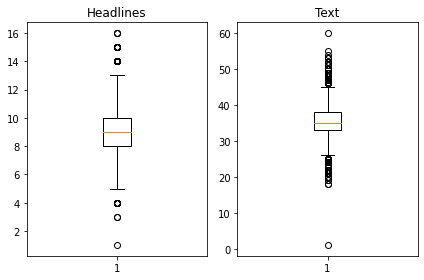

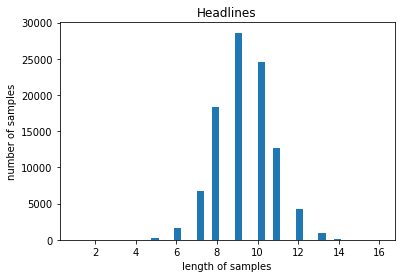

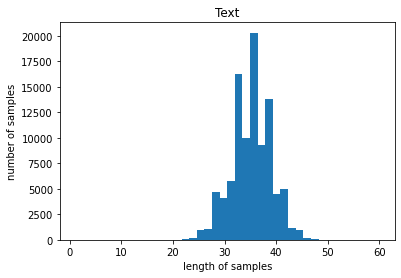

In [48]:
text_len = [len(s.split()) for s in data['text']]
headline_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('제목의 최소 길이 : {}'.format(np.min(headline_len)))
print('제목의 최대 길이 : {}'.format(np.max(headline_len)))
print('제목의 평균 길이 : {}'.format(np.mean(headline_len)))

plt.subplot(1,2,1)
plt.boxplot(headline_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headline_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [49]:
text_max_len = 40
headline_max_len = 10

In [50]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [51]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headline_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.92383627444994
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.816317599886019


In [52]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headline_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 74028


In [53]:
# headline 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)  
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,cong wins ramgarh bypoll in rajasthan takes to...,congress candidate shafia zubair ramgarh assem...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,up cousins fed human excreta for friendship wi...,two minor cousins uttar pradesh gorakhpur alle...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [54]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [55]:
encoder_input.shape

(74028,)

In [56]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[21881 36239 20147 ... 32868  4050 18429]


In [57]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [58]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 14805


In [59]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59223
훈련 레이블의 개수 : 59223
테스트 데이터의 개수 : 14805
테스트 레이블의 개수 : 14805


### step3. 정수 인코딩 

In [60]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
# 생성된 단어는 src_tokenizer.word_index에서 확인 가능 

In [61]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 61570
등장 빈도가 6번 이하인 희귀 단어의 수: 42238
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 19332
단어 집합에서 희귀 단어의 비율: 68.60159168426182
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.185355944326187


In [62]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [63]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[308, 19, 12, 400, 696, 1008, 24, 1147, 5603, 217, 418, 1347, 1042, 178, 523, 155, 333, 10025, 391, 25, 1, 2664, 16, 5535, 6616, 696, 6, 1544, 2804, 10305, 227, 303, 77, 178], [4502, 2470, 39, 2078, 11285, 166, 675, 121, 519, 447, 617, 130, 103, 675, 172, 7, 1563, 2570, 575, 724, 5889, 4906, 7, 68, 297, 576, 519, 5211, 617], [127, 2604, 2820, 18, 224, 83, 16844, 2046, 1312, 13183, 2604, 1219, 7, 635, 6617, 2209, 16844, 874, 25, 1, 1630, 668, 30, 2604, 1312, 1484, 427, 11, 2604, 13183, 184, 7]]


In [64]:
# target
tar_tokenizer = Tokenizer() 
tar_tokenizer.fit_on_texts(decoder_input_train)

In [65]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 27303
등장 빈도가 5번 이하인 희귀 단어의 수: 18263
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9040
단어 집합에서 희귀 단어의 비율: 66.89008533860748
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.011677296970364


In [66]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 116, 3, 72, 36, 59, 457, 2293, 1882], [1, 300, 3, 244, 20, 83, 10, 522, 542, 5, 141], [1, 1318, 1448, 4, 794, 7, 47, 1751, 4, 825], [1, 1883, 2294, 4660, 50, 2937, 7551, 4], [1, 192, 875, 333, 10, 20, 5433, 826, 4, 4884]]
target
decoder  [[116, 3, 72, 36, 59, 457, 2293, 1882, 2], [300, 3, 244, 20, 83, 10, 522, 542, 5, 141, 2], [1318, 1448, 4, 794, 7, 47, 1751, 4, 825, 2], [1883, 2294, 4660, 50, 2937, 7551, 4, 2], [192, 875, 333, 10, 20, 5433, 826, 4, 4884, 2]]


In [67]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [68]:
print(len(drop_train))
drop_train[:5]

0


[]

In [69]:
print(len(drop_test))
drop_test[:5]

0


[]

In [71]:
# 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headline_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headline_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headline_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headline_max_len, padding='post')

#  모델 설계하기

In [72]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [73]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c]) # encoder_lstm3의 hidden state, cell state

In [74]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
# Model(inputs, output) 
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### step3.어텐션 메커니즘 사용하기 (추상적 요약)

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [75]:
# 어텐션 함수 다운로드 
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [76]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [77]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
232/232 [==============================] - 183s 726ms/step - loss: 6.7605 - val_loss: 5.9762
Epoch 2/50
232/232 [==============================] - 169s 727ms/step - loss: 5.9361 - val_loss: 5.6361
Epoch 3/50
232/232 [==============================] - 168s 726ms/step - loss: 5.5896 - val_loss: 5.3554
Epoch 4/50
232/232 [==============================] - 169s 730ms/step - loss: 5.2816 - val_loss: 5.1683
Epoch 5/50
232/232 [==============================] - 169s 728ms/step - loss: 5.0283 - val_loss: 4.9863
Epoch 6/50
232/232 [==============================] - 167s 718ms/step - loss: 4.8143 - val_loss: 4.8674
Epoch 7/50
232/232 [==============================] - 168s 724ms/step - loss: 4.6189 - val_loss: 4.7389
Epoch 8/50
232/232 [==============================] - 169s 727ms/step - loss: 4.4559 - val_loss: 4.6616
Epoch 9/50
232/232 [==============================] - 169s 728ms/step - loss: 4.3161 - val_loss: 4.5850
Epoch 10/50
232/232 [==============================] - 169s 728m

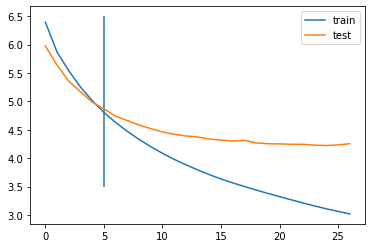

In [78]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.vlines(5, 3.5 ,6.5)
plt.show()

### 인퍼런스 모델 구현하기

In [79]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [80]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [81]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [82]:
def decode_sequence(input_seq):
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headline_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 모델 테스트하기

In [83]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headline(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

### Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [84]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headline(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : maharashtra government new development plan mumbai legally allows functioning restaurants rooftops city currently rooftop bars restaurants operating mumbai either allowed temporary structures illegal decision comes months fire two rooftop eateries city kamala mills left people dead 
실제 요약 : new development plan allows eateries on in mumbai 
예측 요약 :  maharashtra to get new state shops in maharashtra


원문 : former windies captain brian lara became first cricketer history score plus runs first class innings june playing durham lara slammed record runs boundaries world record innings lara spent almost eight hours crease knock 
실제 요약 : lara slammed record in hours hit in and 
예측 요약 :  years since bradman fastest runs to score in tests


원문 : place bay new zealand considered longest place name world letters name roughly translates place man big knees slid climbed swallowed mountains known played loved one 
실제 요약 : longest place name in the world has letters 
예측 요약 :  world st player to 

예측 요약 :  us police to use of chinese drones


원문 : us woman claimed suffering second degree burns arm wrist fitbit flex fitness tracker wearing exploded burst flames woman said doctor remove pieces rubber plastic injured arm fitbit said aware claim investigating incident 
실제 요약 : woman claims of second degree burns from fitbit explosion 
예측 요약 :  woman accidentally shoots inside live during live in


원문 : answering question farmer suicides chhattisgarh agriculture minister agrawal said countries cities developed see suicides common man poor man never commits suicide asserting government schemes helped increase farmers annual income said farmer committed suicide agriculture related issues 
실제 요약 : big cities see suicides poor man never kills self minister 
예측 요약 :  cm announces cm for suicide that killed in


원문 : security agencies put four airports across india high alert till december receiving calls potential bomb threat security increased delhi mumbai lucknow hyderabad airports past

예측 요약 :  trailer of disney released


원문 : least people killed others injured suicide bombing shrine balochistan district suicide attacker tried enter shrine blew stopped police last year least people killed explosion another shrine balochistan 
실제 요약 : at least killed in suicide explosion in balochistan 
예측 요약 :  killed injured in suicide attack in jammu


원문 : commerce giant alibaba said singles day sales surpassed last year total hours hitting record high billion alibaba recorded sales billion last year singles day sale net worth goods sold alibaba platforms reached billion hour sale started midnight 
실제 요약 : alibaba singles day breaks sales record at bn in hrs 
예측 요약 :  amazon overtakes microsoft as most valued company for bn


원문 : diana penty made bollywood debut cocktail said time debut film second film happy bhag jayegi released confusing took figure proceed direction take added time new industry said 
실제 요약 : time between happy bhag was diana 
예측 요약 :  happy film with the thea

### Summa을 이용한 추출적 요약

In [85]:
pip list | grep summa

summa                         1.2.0
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [86]:
import requests
from summa.summarizer import summarize

In [95]:
data_ex = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [102]:
data_ex.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [105]:
for i in range(50):
    print("원문 :", data_ex.iloc[i,1])
    print("실제 요약 :",data_ex.iloc[i,0])
    print("추출적 요약 :", summarize(data_ex.iloc[i,1], ratio = 0.4))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
추출적 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
추출적 요약 : Users get one CRED coin per rupee of bill p

## 결과 분석 

News Summary의 원본이 인도 News Summary 데이터로, 예를 들어 '십만'을 의미하는 lark 와 같은 특수한 단어들이 존재하여 전처리 상에 아쉬움이 많았다. 
이 때문에 요약을 할 원문 자체가 문법성이 많이 제거된 상태로 의미를 지닌 단어들만 남았다보니, 
요약 역시 의미있는 문장이라기보다는 의미있는 단어의 집합으로 나타났다. 
데이터 전처리에 더욱 많은 시간을 쏟았어야했다는 아쉬움이 남는다.

추상적 요약 모델 학습을 위해, 전처리 했던 데이터 기준으로, 요약을 진행하여 다음과 같은 결과를 확인하였다.

- 추상적 요약 
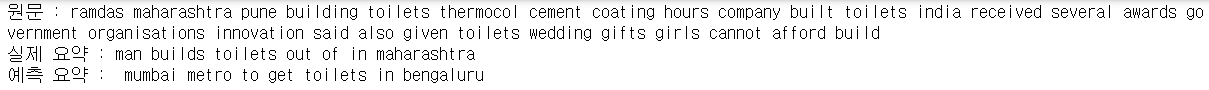
<br/>
<br/>
- 추출적 요약
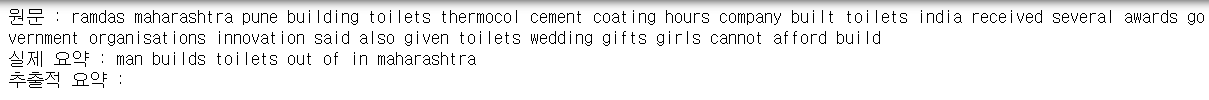

추상적 요약을 위한 전처리를 통하면서, 문장 구분을 위해 필요한 구두점이 사라지고, 문법적 요소들이 많이 사라지면서 <br/>
정상적인 추출적 요약이 이루어지지 않은 것으로 생각되어진다

따라서 정상적인 추출적 요약을 위해서는 문장 구두점 등 요소를 살려둘 필요가 있다

또한, text 원문이  2~3 문장 정도로 짧게 구성되었기 때문에, 낮은 ratio를 적용하면 다음과 같이 결과 출력이 안되는 문제점이 나타났다. 

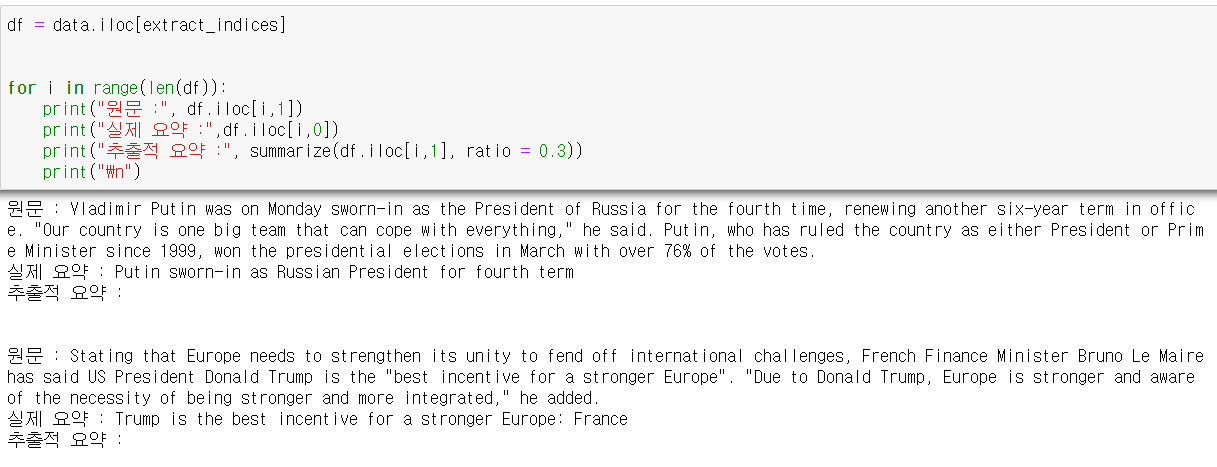

###### 문법 완성도

문법 완성도 측면에서는 전처리를 통해 많은 문법 요소들이 날아간 <br/>
추상적 요약에 비해 추출적 요약이 훌륭한 결과를 보였다. 

###### 핵심 단어 포함 여부

요약해야할 문장이 그리 길지 않는 상태였기 때문에, <br/>
나타난 결과상으로는 추상적 요약과 추출적 요약 간에 큰 차이를 보이지는 않았다. 

종합적으로 판단할 때, 추출적 요약과 추상적 요약은 전통적 기계학습과 딥러닝의 차이점을 보여준다고 할 수 있다. 
이번 데이터의 경우 데이터의 양이 적고, 전처리 과정과 모델링이 비교적 단순했기 때문에, 
전통적 머신러닝 알고리즘인 추출적 요약이 전반적으로 우수한 결과를 보였다.
하지만, 데이터의 양이 늘어나고, 레이어의 갯수가 늘어난다면, 
특히 긴 문장을 요약하는 태스크의 경우, 추상적 요약이 더욱 우수한 결과를 낼 수 있을 것이라 기대된다. 